# Supervised learning portion

In [1]:
# importing packages
import pandas as pd
import numpy as np
import sys
import codecs
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("/Users/arturoavila/Documents/Milestone II Project/spotify-market-popularity/functions")
# importing fuctions we created
from feature_engineering import *
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA

In [2]:
audio_path, artists_path, playlists_path = (
    r"../../data/spotify_audio_features.json",
    r"../../data/spotify_artists.json",
    r"../../data/spotify_top_50_playlists.json",
)

In [3]:
artists, tracks = get_data(audio_path, artists_path, playlists_path)
# display(artists.head())
# display(tracks.head())

In [4]:
# tracks.groupby('market_id')['track_id'].count().reset_index()

In [5]:
tracks["artist_id"] = tracks["artist_ids"].apply(lambda x: x[0]["id"] if (x and "id" in x[0]) else None)

In [6]:
tracks.loc[tracks["artist_id"] == "6DARBhWbfcS9E4yJzcliqQ"]

,track_id,track_name,playlist_id,album_type,album_id,artist_ids,explicit,track_popularity,market_id,num_avail_markets,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artist_id
1824,0YQJoDL6f46J0n1rOVkpxJ,Softly,37i9dQZEVXbMWDif5SCBJq,album,3BGU0BqGwBkYDHpfCWFm7I,"[{'id': '6DARBhWbfcS9E4yJzcliqQ'}, {'id': '3nq...",False,77,india,183,...,1,0.2040,0.1910,0.0,0.0791,0.902,92.986,155161,4,6DARBhWbfcS9E4yJzcliqQ
1836,6ygiy70ujkNOYXM1tQuMNe,Admirin' You (feat. Preston Pablo),37i9dQZEVXbMWDif5SCBJq,album,3BGU0BqGwBkYDHpfCWFm7I,"[{'id': '6DARBhWbfcS9E4yJzcliqQ'}, {'id': '3nq...",False,73,india,183,...,1,0.0851,0.0935,0.0,0.1040,0.675,96.018,214750,4,6DARBhWbfcS9E4yJzcliqQ
1860,1Er6TEtbyuW1b9QtBVkggD,Jee Ni Lagda,37i9dQZEVXbMWDif5SCBJq,album,3BGU0BqGwBkYDHpfCWFm7I,"[{'id': '6DARBhWbfcS9E4yJzcliqQ'}, {'id': '3nq...",False,76,india,183,...,0,0.1920,0.3380,0.0,0.1300,0.907,93.005,139355,4,6DARBhWbfcS9E4yJzcliqQ
2350,2uWZ7EGddFlA1DJ3Rzzvs2,Bachke Bachke (feat. Yarah),37i9dQZEVXbNy9tB5elXf1,album,3BGU0BqGwBkYDHpfCWFm7I,"[{'id': '6DARBhWbfcS9E4yJzcliqQ'}, {'id': '3nq...",False,77,pakistan,183,...,0,0.0861,0.3940,0.0,0.3930,0.461,88.086,210118,4,6DARBhWbfcS9E4yJzcliqQ


In [7]:
df = artists.merge(tracks, on="artist_id")
# df.rename(columns={'market_id': 'country'}, inplace=True)
df.columns

Index(['artist_id', 'artist_name', 'followers', 'genres', 'popularity',
       'parent_genre', 'track_id', 'track_name', 'playlist_id', 'album_type',
       'album_id', 'artist_ids', 'explicit', 'track_popularity', 'market_id',
       'num_avail_markets', 'num_artists', 'playlist_rank',
       'tot_artist_followers', 'avg_artist_popularity', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature'],
      dtype='object')

In [8]:
# df.groupby('market_id')['track_id'].count().reset_index()

In [9]:
# Testing whether the first id on artist_id is the main artist
feats = df[df["track_name"].str.contains("feat")]
feats[["track_name", "artist_name", "artist_id", "artist_ids"]]

,track_name,artist_name,artist_id,artist_ids
7,Admirin' You (feat. Preston Pablo),Karan Aujla,6DARBhWbfcS9E4yJzcliqQ,"[{'id': '6DARBhWbfcS9E4yJzcliqQ'}, {'id': '3nq..."
9,Bachke Bachke (feat. Yarah),Karan Aujla,6DARBhWbfcS9E4yJzcliqQ,"[{'id': '6DARBhWbfcS9E4yJzcliqQ'}, {'id': '3nq..."
130,Comforter (feat. Ayra Starr),ElGrandeToto,4BFLElxtBEdsdwGA1kHTsx,"[{'id': '4BFLElxtBEdsdwGA1kHTsx'}, {'id': '3Zp..."
162,"MIRAGE (feat. Ozuna, GIMS & Sfera Ebbasta)",AriBeatz,6cNWiizYLCClZdnIvqU968,"[{'id': '6cNWiizYLCClZdnIvqU968'}, {'id': '1i8..."
193,xoxo (feat. ICEKIID),Artigeardit,6a3WaWgxrVmNIvaiTCI0Kk,"[{'id': '6a3WaWgxrVmNIvaiTCI0Kk'}, {'id': '4Zw..."
...,...,...,...,...
2864,Arranca (feat. Omega),Becky G,4obzFoKoKRHIphyHzJ35G3,"[{'id': '4obzFoKoKRHIphyHzJ35G3'}, {'id': '1Uj..."
2865,Arranca (feat. Omega),Becky G,4obzFoKoKRHIphyHzJ35G3,"[{'id': '4obzFoKoKRHIphyHzJ35G3'}, {'id': '1Uj..."
2866,Arranca (feat. Omega),Becky G,4obzFoKoKRHIphyHzJ35G3,"[{'id': '4obzFoKoKRHIphyHzJ35G3'}, {'id': '1Uj..."
2882,Gangnam Style (feat. DJ Maphorisa & Kabza De S...,Mas Musiq,3fdFRgy3GmfiWQqeKbmFS8,"[{'id': '3fdFRgy3GmfiWQqeKbmFS8'}, {'id': '0oW..."


In [10]:
artists["parent_genre"].isna().sum()

413

In [11]:
# pip install seaborn

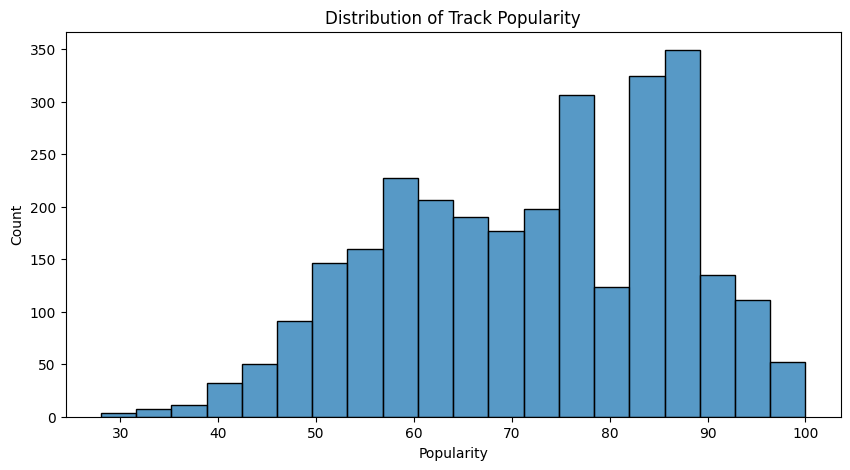

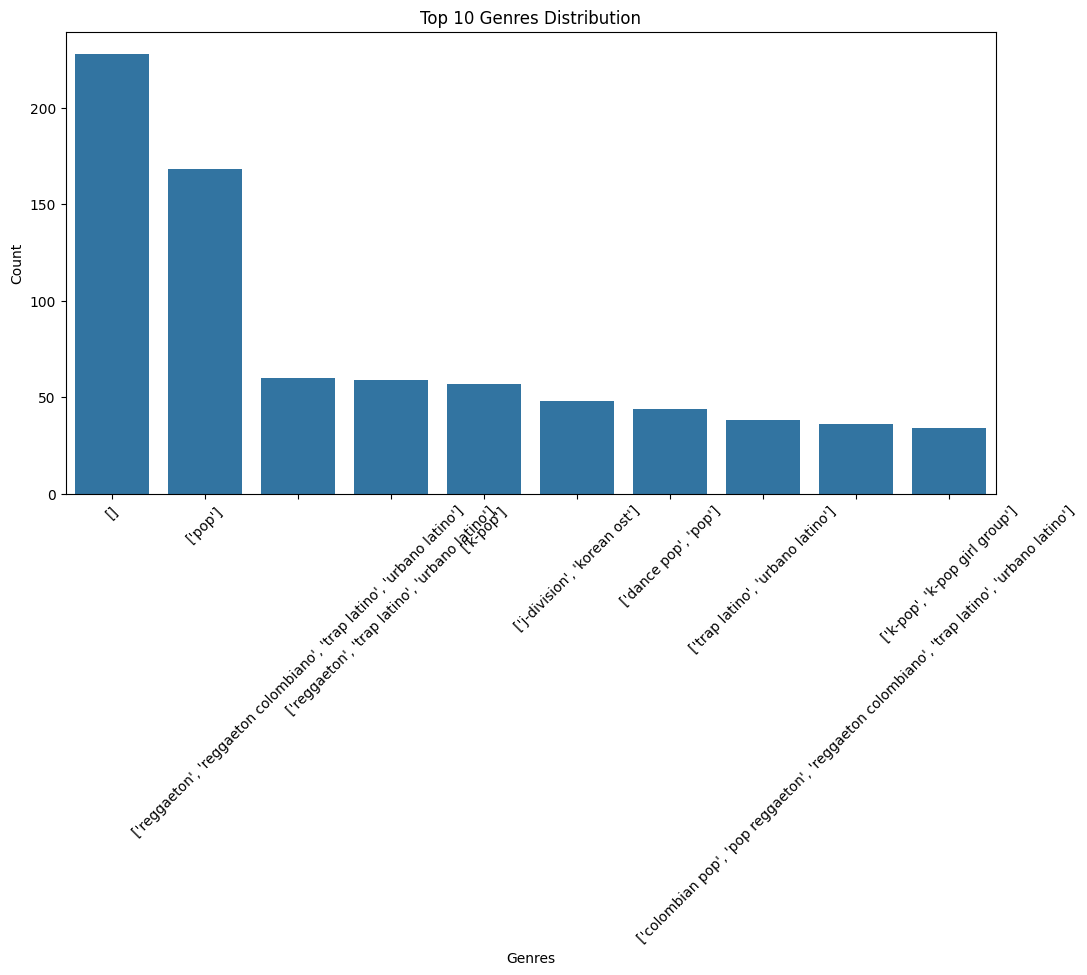

ValueError: could not convert string to float: '2CKOmarVWvWqkNWUatHCex'

<Figure size 1200x800 with 0 Axes>

In [11]:
# Distribution of Popularity (Histogram)
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="popularity", bins=20)
plt.title("Distribution of Track Popularity")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.show()

# Genre Distribution (Bar Chart)
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="genres", order=df["genres"].value_counts().index[:10])
plt.title("Top 10 Genres Distribution")
plt.xlabel("Genres")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Scatter Plot of Danceability vs. Energy
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="danceability", y="energy", hue="explicit", alpha=0.5)
plt.title("Danceability vs. Energy")
plt.xlabel("Danceability")
plt.ylabel("Energy")
plt.show()

# Market Distribution (Bar Chart)
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="market_id")
plt.title("Distribution of Tracks in Markets")
plt.xlabel("Market ID")
plt.ylabel("Count")
plt.show()

# Artist Followers vs. Popularity (Scatter Plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="tot_artist_followers", y="track_popularity", hue="explicit", alpha=0.5)
plt.title("Artist Followers vs. Track Popularity")
plt.xlabel("Total Artist Followers")
plt.ylabel("Track Popularity")
plt.show()

# Playlist Rank vs. Track Popularity (Scatter Plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="playlist_rank", y="track_popularity", alpha=0.5)
plt.title("Playlist Rank vs. Track Popularity")
plt.xlabel("Playlist Rank")
plt.ylabel("Track Popularity")
plt.show()

# Feature transformation

In [13]:
columns_to_drop = ["artist_id", "track_id", "playlist_id", "album_id", "artist_ids"]
df = df.drop(columns=columns_to_drop)

In [14]:
label_encoders = {}
for column in ["artist_name", "track_name", "album_type", "parent_genre"]:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [15]:
mlb = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(mlb.fit_transform(df["genres"]), columns=mlb.classes_, index=df.index)
df = pd.concat([df.drop("genres", axis=1), genres_encoded], axis=1)

In [16]:
df.columns

Index(['artist_name', 'followers', 'popularity', 'parent_genre', 'track_name',
       'album_type', 'explicit', 'track_popularity', 'market_id',
       'num_avail_markets',
       ...
       'vietnamese melodic rap', 'vietnamese trap', 'viral afropop',
       'viral pop', 'west coast rap', 'yacht rock', 'yemeni pop',
       'zhenskiy rep', 'zhongguo feng', 'zxc'],
      dtype='object', length=579)

# Baseline model

In [17]:
# Assuming you've already done your train/test split and preprocessing

# Instantiate the model
# 'ovr' stands for One-vs-Rest. For softmax regression, you can use 'multinomial'.
X = df.drop("market_id", axis=1)
y = df["market_id"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_reg = LogisticRegression(solver="lbfgs", multi_class="ovr", max_iter=10000)

# Train the model
log_reg.fit(X_train, y_train)

# Predict
y_pred = log_reg.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))

# Predict
y_pred = log_reg.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

                    precision    recall  f1-score   support

         argentina       0.05      0.17      0.08         6
         australia       0.00      0.00      0.00        14
           austria       0.00      0.00      0.00        10
           belarus       0.18      0.18      0.18        11
           belgium       0.00      0.00      0.00        11
            brazil       0.00      0.00      0.00         8
            canada       0.00      0.00      0.00        12
             chile       0.03      0.29      0.06         7
          colombia       0.00      0.00      0.00        12
    czech_republic       0.00      0.00      0.00        15
           denmark       0.00      0.00      0.00         7
dominican_republic       0.00      0.00      0.00        13
           ecuador       0.00      0.00      0.00        12
             egypt       0.00      0.00      0.00         8
           finland       0.23      0.27      0.25        11
            france       0.00      0.00

/Users/arturoavila/Library/Caches/pypoetry/virtualenvs/spotify-market-popularity-JDTflhsm-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arturoavila/Library/Caches/pypoetry/virtualenvs/spotify-market-popularity-JDTflhsm-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arturoavila/Library/Caches/pypoetry/virtualenvs/spotify-market-popularity-JDTflhsm-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and

# All features

In [18]:
# Train/Test Split
X = df.drop("market_id", axis=1)
y = df["market_id"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train different models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
}

# Create a Voting Classifier that combines multiple models
voting_classifier = VotingClassifier(estimators=[(name, model) for name, model in models.items()], voting="hard")
models["Voting Classifier"] = voting_classifier

# Initialize a list to store the results
results = []

for model_name, model in models.items():
    model.fit(X_train, y_train)

    # Evaluation
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Append the results to the list as a dictionary
    results.append({"Model Name": model_name, "Accuracy": accuracy, "Classification Report": report})

/Users/arturoavila/Library/Caches/pypoetry/virtualenvs/spotify-market-popularity-JDTflhsm-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/arturoavila/Library/Caches/pypoetry/virtualenvs/spotify-market-popularity-JDTflhsm-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/User

In [19]:
for result in results:
    print(f"Model Name: {result['Model Name']}")
    print(f"Accuracy: {result['Accuracy'] * 100:.2f}%")
    print("\n")

Model Name: Random Forest
Accuracy: 35.00%


Model Name: Logistic Regression
Accuracy: 35.00%


Model Name: SVM
Accuracy: 36.90%


Model Name: AdaBoost
Accuracy: 4.14%


Model Name: Gradient Boosting
Accuracy: 33.79%


Model Name: Voting Classifier
Accuracy: 35.86%




In [20]:
# Train/Test Split
X = df.drop("market_id", axis=1)
y = df["market_id"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Model Selection and Training
model = RandomForestClassifier(n_estimators=100, random_state=42)
# model = SVC()
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using Random Forest Classifier: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))

Accuracy using Random Forest Classifier: 35.00%
                    precision    recall  f1-score   support

         argentina       0.50      0.67      0.57         6
         australia       0.00      0.00      0.00        14
           austria       0.00      0.00      0.00        10
           belarus       0.67      0.73      0.70        11
           belgium       0.00      0.00      0.00        11
            brazil       1.00      0.88      0.93         8
            canada       0.00      0.00      0.00        12
             chile       0.25      0.43      0.32         7
          colombia       0.10      0.08      0.09        12
    czech_republic       0.44      0.27      0.33        15
           denmark       0.56      0.71      0.63         7
dominican_republic       0.15      0.15      0.15        13
           ecuador       0.00      0.00      0.00        12
             egypt       1.00      0.88      0.93         8
           finland       0.62      0.73      0.67  

In [21]:
X = df.drop("market_id", axis=1)
y = df["market_id"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Selection and Training
model = SVC()
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Use the zero_division parameter to control the behavior of metrics
report = classification_report(y_test, y_pred, zero_division=1)

print(f"Accuracy using SVM Classifier: {accuracy * 100:.2f}%")
print("Classification Report:")
print(report)

Accuracy using SVM Classifier: 36.90%
Classification Report:
                    precision    recall  f1-score   support

         argentina       0.60      1.00      0.75         6
         australia       1.00      0.00      0.00        14
           austria       1.00      0.00      0.00        10
           belarus       1.00      0.45      0.62        11
           belgium       0.00      0.00      1.00        11
            brazil       1.00      0.62      0.77         8
            canada       0.25      0.08      0.12        12
             chile       1.00      0.57      0.73         7
          colombia       0.14      0.25      0.18        12
    czech_republic       0.50      0.27      0.35        15
           denmark       1.00      0.71      0.83         7
dominican_republic       1.00      0.23      0.38        13
           ecuador       0.00      0.00      1.00        12
             egypt       1.00      0.88      0.93         8
           finland       1.00      0.7

# Most correlated features per country

In [22]:
def get_country_correlations(merged_df: pd.DataFrame):
    country_list = np.sort(merged_df["market_id"].unique()).tolist()
    # correlation_list = np.sort(corr_variables)
    correlation_dic = {}

    df1 = merged_df.select_dtypes(exclude=["object", "bool"])

    df1 = df1.drop("track_popularity", axis=1)
    corr_variables = df1.columns.tolist()

    corr_var_dic = {"Rank": ["1st", "2nd"]}
    for country in country_list:
        df2 = df1[merged_df["market_id"] == country]
        corr_matrix = get_correlation_matrix(df2, corr_variables)
        corr_matrix = corr_matrix.reset_index()
        # rank_matrix = corr_matrix[corr_matrix["index"] == "playlist_rank"]
        dic = {corr_matrix["index"][i]: corr_matrix["playlist_rank"][i] for i in range(len(corr_matrix))}

        var1 = sorted(dic, key=dic.get)[0]
        var2 = sorted(dic, key=dic.get)[1]

        corr_var_dic[country] = [var1, var2]
        correlation_dic[country] = {var1: dic[var1], var2: dic[var2]}

    top_df = pd.DataFrame.from_dict(corr_var_dic)  # .reset_index().rename(columns= {"index": "rank"})
    top_variables_df = pd.melt(
        top_df,
        id_vars=["Rank"],
        ignore_index=True,
        value_vars=top_df.columns[1:],
        var_name="Country",
        value_name="Top_Variable",
    )
    top_df_final = top_variables_df.pivot_table(columns="Rank", index="Country", values="Top_Variable", aggfunc="first")

    return correlation_dic, top_df_final


def get_correlation_matrix(df, corr_feats: list = None):
    df2 = df.select_dtypes(exclude=["object", "bool"])
    if corr_feats:
        corr_df = df[corr_feats]
    # corr = corr_df.corr()
    else:
        corr_df = df2
    # plt.figure(figsize=(18, 10))
    # sns.heatmap(corr, annot=True)

    return corr_df.corr()

In [23]:
correlation_dic, top_df_final = get_country_correlations(df)

In [24]:
top_df_final.head()

Rank,1st,2nd
Country,,
argentina,danceability,avg_artist_popularity
australia,num_avail_markets,album_type
austria,parent_genre,alt z
belarus,tot_artist_followers,followers
belgium,parent_genre,duration_ms


In [25]:
country_models = {}  # Dictionary to store models for each country

for country, row in top_df_final.iterrows():
    features = [row["1st"], row["2nd"]]

    # Filter dataset for the specific country and features
    country_data = df[df["market_id"] == country]
    X = country_data[features]
    y = country_data["market_id"]  # Assuming 'market_id' is the target variable

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Optional: Evaluate model (this is just an example, adapt as needed)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {country}: {accuracy * 100:.2f}%")

    # Store the trained model
    country_models[country] = model

Accuracy for argentina: 100.00%
Accuracy for australia: 100.00%
Accuracy for austria: 100.00%
Accuracy for belarus: 100.00%
Accuracy for belgium: 100.00%
Accuracy for brazil: 100.00%
Accuracy for canada: 100.00%
Accuracy for chile: 100.00%
Accuracy for colombia: 100.00%
Accuracy for czech_republic: 100.00%
Accuracy for denmark: 100.00%
Accuracy for dominican_republic: 100.00%
Accuracy for ecuador: 100.00%
Accuracy for egypt: 100.00%
Accuracy for finland: 100.00%
Accuracy for france: 100.00%
Accuracy for germany: 100.00%
Accuracy for global: 100.00%
Accuracy for guatemala: 100.00%
Accuracy for hong_kong: 100.00%
Accuracy for hungary: 100.00%
Accuracy for india: 100.00%
Accuracy for indonesia: 100.00%
Accuracy for ireland: 100.00%
Accuracy for israel: 100.00%
Accuracy for italy: 100.00%
Accuracy for japan: 100.00%
Accuracy for kazakhstan: 100.00%
Accuracy for malaysia: 100.00%
Accuracy for mexico: 100.00%
Accuracy for morocco: 100.00%
Accuracy for netherlands: 100.00%
Accuracy for new_ze

In [26]:
country = "venezuela"
country_data = df[df["market_id"] == country]
X = country_data[["key", "acousticness"]]
y = country_data["market_id"]  # Assuming 'market_id' is the target variable

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Optional: Evaluate model (this is just an example, adapt as needed)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for {country}: {accuracy * 100:.2f}%")

Accuracy for venezuela: 100.00%


In [27]:
# df[df['market_id'] == 'venezuela']

In [28]:
# #Cleaning Artist ID
# playlist_df['artist_id'] = playlist_df['artist_ids'].apply(lambda x: x[0]['id'] if (x and 'id' in x[0]) else None)

# #Joining
# df_join = artist_df.merge(playlist_df, on="artist_id")
# df = df_join.merge(audio_df, on="track_id")
# df.head()

# Top n correlated features

In [29]:
# Combine the '1st' and '2nd' columns
combined_features = pd.concat([top_df_final["1st"], top_df_final["2nd"]])

# Get the top 5 most common features
top_5_features = combined_features.value_counts().head(5).index.tolist()

top_5_features

['album_type',
 'key',
 'num_avail_markets',
 'track_name',
 'avg_artist_popularity']

In [30]:
X = df[top_5_features]
# X = df[['danceability','avg_artist_popularity']]
y = df["market_id"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Selection and Training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using Random Forest Classifier: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))

Accuracy using Random Forest Classifier: 11.72%
                    precision    recall  f1-score   support

         argentina       0.07      0.17      0.10         6
         australia       0.00      0.00      0.00        14
           austria       0.00      0.00      0.00        10
           belarus       0.11      0.09      0.10        11
           belgium       0.00      0.00      0.00        11
            brazil       0.22      0.25      0.24         8
            canada       0.00      0.00      0.00        12
             chile       0.08      0.14      0.11         7
          colombia       0.00      0.00      0.00        12
    czech_republic       0.15      0.13      0.14        15
           denmark       0.20      0.14      0.17         7
dominican_republic       0.00      0.00      0.00        13
           ecuador       0.00      0.00      0.00        12
             egypt       0.50      0.50      0.50         8
           finland       0.13      0.18      0.15  

In [31]:
# delete probably
# Playlist genres encoding

# df = artists.merge(tracks, on="artist_id")
# df.columns

In [32]:
df.head()

,artist_name,followers,popularity,parent_genre,track_name,album_type,explicit,track_popularity,market_id,num_avail_markets,...,vietnamese melodic rap,vietnamese trap,viral afropop,viral pop,west coast rap,yacht rock,yemeni pop,zhenskiy rep,zhongguo feng,zxc
0,66,2932225,82,1,1112,2,False,87,brazil,184,...,0,0,0,0,0,0,0,0,0,0
1,66,2932225,82,1,1256,2,False,80,brazil,184,...,0,0,0,0,0,0,0,0,0,0
2,126,8035,52,2,1249,2,False,65,norway,184,...,0,0,0,0,0,0,0,0,0,0
3,126,8035,52,2,434,2,False,62,norway,184,...,0,0,0,0,0,0,0,0,0,0
4,520,709383,67,9,990,2,False,83,philippines,183,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# Predicting track_popularity


# X = df.drop('track_popularity', axis=1)
# y = df['track_popularity']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Model Selection and Training
# model = LinearRegression()
# model.fit(X_train, y_train)

# # Evaluation
# y_pred = model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# print(f"Mean Squared Error: {mse}")

# Doing Recursive Feature Engineering

In [34]:
# Applying RFE to get some features


# df.fillna(value=0, inplace=True)
# # Train/Test Split
# X = df.drop('market_id', axis=1)
# y = df['market_id']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Model Selection
# model = RandomForestClassifier(n_estimators=100, random_state=42)

# # Apply RFE
# # Here, we'll choose the top 10 features. You can adjust this number as desired.
# selector = RFE(estimator=model, n_features_to_select=10, step=1)
# selector = selector.fit(X_train, y_train)

# # Refit the model using only the selected features
# X_train_rfe = selector.transform(X_train)
# X_test_rfe = selector.transform(X_test)
# model.fit(X_train_rfe, y_train)

# # Evaluation
# y_pred = model.predict(X_test_rfe)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy using Random Forest Classifier with RFE-selected features: {accuracy * 100:.2f}%")
# print(classification_report(y_test, y_pred))

# # If you want to see which features were selected:
# selected_features = pd.Series(selector.support_, index=X.columns)
# print("Selected features:")
# print(selected_features[selected_features].index.tolist())

In [35]:
# Uisng RFEs
rfes = [
    "artist_name",
    "followers",
    "track_name",
    "track_popularity",
    "playlist_rank",
    "tot_artist_followers",
    "avg_artist_popularity",
    "loudness",
    "speechiness",
    "duration_ms",
]
top_5_features

# Train/Test Split
X = df[rfes]
# X = df[['danceability','avg_artist_popularity']]
y = df["market_id"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Selection and Training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using Random Forest Classifier: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))

Accuracy using Random Forest Classifier: 23.10%
                    precision    recall  f1-score   support

         argentina       0.11      0.17      0.13         6
         australia       0.00      0.00      0.00        14
           austria       0.00      0.00      0.00        10
           belarus       0.62      0.45      0.53        11
           belgium       0.00      0.00      0.00        11
            brazil       0.30      0.38      0.33         8
            canada       0.00      0.00      0.00        12
             chile       0.20      0.29      0.24         7
          colombia       0.00      0.00      0.00        12
    czech_republic       0.40      0.27      0.32        15
           denmark       0.31      0.57      0.40         7
dominican_republic       0.00      0.00      0.00        13
           ecuador       0.00      0.00      0.00        12
             egypt       0.86      0.75      0.80         8
           finland       0.33      0.36      0.35  

# Using Top n important features

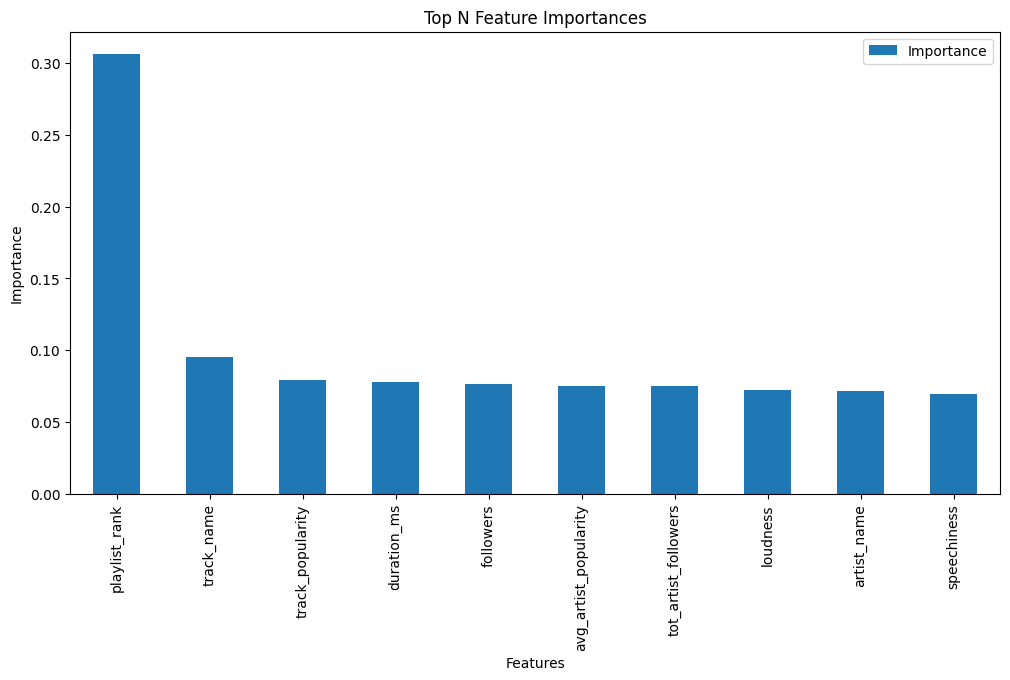

In [36]:
# Extract feature importances
importances = model.feature_importances_
features = X.columns

# Create a DataFrame for visualization
feature_df = pd.DataFrame({"Features": features, "Importance": importances})

# Sort the features based on importance
feature_df = feature_df.sort_values(by="Importance", ascending=False)

# Plot the top N features
N = 10  # Change N to display more or fewer features
feature_df.head(N).plot(x="Features", y="Importance", kind="bar", figsize=(12, 6))
plt.title("Top N Feature Importances")
plt.ylabel("Importance")
plt.show()

In [37]:
feature_counts = [5, 10, 15, 20, 25]

for num_features in feature_counts:
    # Get the top 'num_features' features
    top_features = feature_df["Features"].head(num_features).tolist()

    # Filter dataset to use only the top 'num_features' features
    X_top_features = X[top_features]
    X_train, X_test, y_train, y_test = train_test_split(X_top_features, y, test_size=0.2, random_state=42)

    # Model Selection and Training
    model_top_features = RandomForestClassifier(n_estimators=100, random_state=42)
    model_top_features.fit(X_train, y_train)

    # Evaluation
    y_pred = model_top_features.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy using Random Forest Classifier with Top {num_features} Features: {accuracy * 100:.2f}%")

Accuracy using Random Forest Classifier with Top 5 Features: 18.79%
Accuracy using Random Forest Classifier with Top 10 Features: 23.97%
Accuracy using Random Forest Classifier with Top 15 Features: 23.97%
Accuracy using Random Forest Classifier with Top 20 Features: 23.97%
Accuracy using Random Forest Classifier with Top 25 Features: 23.97%


# Hyperparameter tuning

In [38]:
# Train/Test Split
X = df.drop("market_id", axis=1)
y = df["market_id"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define a range of hyperparameters to search
param_grid = {
    "C": [0.1, 1, 10],  # Regularization parameter
    "kernel": ["linear", "rbf"],  # Kernel type
    "gamma": ["scale", "auto", 0.1, 1],  # Kernel coefficient
}

# Create the SVM classifier
svm = SVC()

# Initialize Grid Search with cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring="accuracy")

# Perform Grid Search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)

# Evaluation on the test set
y_pred = best_svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Use the zero_division parameter to control the behavior of metrics
report = classification_report(y_test, y_pred, zero_division=1)

print(f"Best Hyperparameters: {best_params}")
print(f"Accuracy using SVM Classifier with Best Hyperparameters: {accuracy * 100:.2f}%")
print("Classification Report:")
print(report)

Best Hyperparameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy using SVM Classifier with Best Hyperparameters: 34.14%
Classification Report:
                    precision    recall  f1-score   support

         argentina       0.75      1.00      0.86         6
         australia       0.00      0.00      1.00        14
           austria       0.00      0.00      1.00        10
           belarus       0.86      0.55      0.67        11
           belgium       0.00      0.00      1.00        11
            brazil       1.00      0.75      0.86         8
            canada       0.08      0.08      0.08        12
             chile       1.00      0.57      0.73         7
          colombia       0.15      0.25      0.19        12
    czech_republic       0.50      0.27      0.35        15
           denmark       1.00      0.71      0.83         7
dominican_republic       0.29      0.15      0.20        13
           ecuador       0.00      0.00      1.00        12
 

# Cross-Validation

In [39]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create the SVM classifier
svm = SVC(C=1.0, kernel="rbf", gamma="scale")

# Perform cross-validation (5-fold in this example)
cv_scores = cross_val_score(svm, X_scaled, y, cv=5, scoring="accuracy")

# Train the model on the entire dataset
svm.fit(X_scaled, y)

# Evaluate the model using cross-validation results
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy: {:.2f}%".format(cv_scores.mean() * 100))
print("Standard Deviation: {:.2f}".format(cv_scores.std()))

# Optionally, you can also report other metrics like classification report
y_pred = svm.predict(X_scaled)
report = classification_report(y, y_pred)

print("Classification Report:")
print(report)

Cross-Validation Accuracy Scores: [0.32758621 0.3137931  0.37413793 0.35517241 0.31778929]
Mean Accuracy: 33.77%
Standard Deviation: 0.02
Classification Report:
                    precision    recall  f1-score   support

         argentina       0.61      0.74      0.67        50
         australia       0.37      0.14      0.20        50
           austria       0.27      0.14      0.18        50
           belarus       0.73      0.76      0.75        50
           belgium       0.38      0.06      0.10        50
            brazil       1.00      0.96      0.98        50
            canada       0.42      0.10      0.16        50
             chile       0.93      0.56      0.70        50
          colombia       0.19      0.48      0.27        50
    czech_republic       0.67      0.64      0.65        50
           denmark       1.00      0.68      0.81        50
dominican_republic       0.92      0.24      0.38        50
           ecuador       0.27      0.06      0.10        5

# Regularization

In [40]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Regularization parameter C (adjust this value as needed)
C = 1.0

# Create the SVM classifier with regularization
svm = SVC(C=C, kernel="rbf", gamma="scale")

# Train the SVM model
svm.fit(X_train, y_train)

# Predict on the test set
y_pred = svm.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Generate a classification report
report = classification_report(y_test, y_pred)

print(f"Accuracy using SVM Classifier with Regularization (C={C}): {accuracy * 100:.2f}%")
print("Classification Report:")
print(report)

Accuracy using SVM Classifier with Regularization (C=1.0): 36.03%
Classification Report:
                    precision    recall  f1-score   support

         argentina       0.40      1.00      0.57         6
         australia       0.00      0.00      0.00        14
           austria       0.00      0.00      0.00        10
           belarus       1.00      0.36      0.53        11
           belgium       0.00      0.00      0.00        11
            brazil       1.00      0.62      0.77         8
            canada       0.25      0.08      0.12        12
             chile       1.00      0.57      0.73         7
          colombia       0.14      0.17      0.15        12
    czech_republic       0.67      0.27      0.38        15
           denmark       1.00      0.57      0.73         7
dominican_republic       1.00      0.23      0.38        13
           ecuador       0.00      0.00      0.00        12
             egypt       1.00      0.88      0.93         8
          

/Users/arturoavila/Library/Caches/pypoetry/virtualenvs/spotify-market-popularity-JDTflhsm-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arturoavila/Library/Caches/pypoetry/virtualenvs/spotify-market-popularity-JDTflhsm-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arturoavila/Library/Caches/pypoetry/virtualenvs/spotify-market-popularity-JDTflhsm-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and

# Regularization + Cross-Validation + Hyperparameter Tuning

In [41]:
C = 1.0

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create the SVM classifier with regularization
svm = SVC(C=C, kernel="rbf", gamma="scale")

# Train the SVM model
svm.fit(X_train, y_train)

# Step 2: Cross-Validation
# Perform cross-validation (5-fold in this example)
cv_scores = cross_val_score(svm, X_scaled, y, cv=5, scoring="accuracy")

# Calculate mean accuracy and standard deviation
mean_accuracy = cv_scores.mean()
std_deviation = cv_scores.std()

# Step 3: Hyperparameter Tuning
# Define a range of hyperparameters to search
param_grid = {
    "C": [0.1, 1, 10],  # Regularization parameter
    "kernel": ["linear", "rbf"],  # Kernel type
    "gamma": ["scale", "auto", 0.1, 1],  # Kernel coefficient
}

# Initialize Grid Search with cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring="accuracy")

# Perform Grid Search to find the best hyperparameters
grid_search.fit(X_scaled, y)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Create the SVM classifier with the best hyperparameters
best_svm = SVC(**best_params)

# Train the SVM model with the best hyperparameters
best_svm.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = best_svm.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Generate a classification report
report = classification_report(y_test, y_pred)

# Print the results
print(f"Regularization with C={C}:")
print(f"Cross-Validation Mean Accuracy: {mean_accuracy:.2f}")
print(f"Cross-Validation Standard Deviation: {std_deviation:.2f}")
print(f"Best Hyperparameters: {best_params}")
print(f"Accuracy with Best Hyperparameters: {accuracy * 100:.2f}%")
print("Classification Report:")
print(report)

Regularization with C=1.0:
Cross-Validation Mean Accuracy: 0.34
Cross-Validation Standard Deviation: 0.02
Best Hyperparameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy with Best Hyperparameters: 34.48%
Classification Report:
                    precision    recall  f1-score   support

         argentina       0.75      1.00      0.86         6
         australia       0.00      0.00      0.00        14
           austria       0.00      0.00      0.00        10
           belarus       0.86      0.55      0.67        11
           belgium       0.00      0.00      0.00        11
            brazil       1.00      0.75      0.86         8
            canada       0.08      0.08      0.08        12
             chile       1.00      0.57      0.73         7
          colombia       0.16      0.25      0.19        12
    czech_republic       0.56      0.33      0.42        15
           denmark       1.00      0.71      0.83         7
dominican_republic       0.29      0

# PCA

In [42]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA with a specified number of components
n_components = 10  # Adjust this number as needed
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Variance explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_
total_variance_explained = explained_variance_ratio.sum()

# Print the explained variance ratios
print("Explained Variance Ratios:")
for i, explained_variance in enumerate(explained_variance_ratio):
    print(f"PC{i + 1}: {explained_variance:.4f}")

print(f"Total Variance Explained: {total_variance_explained:.2%}")

Explained Variance Ratios:
PC1: 0.0139
PC2: 0.0107
PC3: 0.0092
PC4: 0.0087
PC5: 0.0080
PC6: 0.0075
PC7: 0.0073
PC8: 0.0070
PC9: 0.0068
PC10: 0.0066
Total Variance Explained: 8.58%


In [43]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Perform PCA with a specified number of components
n_components = 10  # Adjust this number as needed
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Create and train a classification model (e.g., SVM) on the reduced data
svm = SVC(C=1.0, kernel="rbf", gamma="scale")
svm.fit(X_train_pca, y_train)

# Predict on the test set using the reduced data
y_pred = svm.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Generate a classification report
report = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy using SVM Classifier with PCA: {accuracy * 100:.2f}%")
print("Classification Report:")
print(report)

Accuracy using SVM Classifier with PCA: 15.86%
Classification Report:
                    precision    recall  f1-score   support

         argentina       0.02      0.17      0.04         6
         australia       0.00      0.00      0.00        14
           austria       0.00      0.00      0.00        10
           belarus       1.00      0.18      0.31        11
           belgium       0.00      0.00      0.00        11
            brazil       1.00      0.62      0.77         8
            canada       0.00      0.00      0.00        12
             chile       0.00      0.00      0.00         7
          colombia       0.16      0.50      0.24        12
    czech_republic       0.00      0.00      0.00        15
           denmark       0.10      0.43      0.16         7
dominican_republic       0.00      0.00      0.00        13
           ecuador       0.00      0.00      0.00        12
             egypt       0.38      0.38      0.38         8
           finland       0.21

/Users/arturoavila/Library/Caches/pypoetry/virtualenvs/spotify-market-popularity-JDTflhsm-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arturoavila/Library/Caches/pypoetry/virtualenvs/spotify-market-popularity-JDTflhsm-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arturoavila/Library/Caches/pypoetry/virtualenvs/spotify-market-popularity-JDTflhsm-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and